# **RNN Introduction**


## Importing required libraries


In [1]:
!pip install mplfinance

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 75.0/75.0 kB 1.3 MB/s eta 0:00:00


In [28]:
import pandas as pd
import numpy as np
import warnings
warnings.filterwarnings("ignore")

import math
import random
import datetime as dt
import matplotlib.dates as mdates

import matplotlib.pyplot as plt
from mplfinance.original_flavor import candlestick_ohlc

from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import SimpleRNN, Dense, Dropout
from keras.callbacks import ModelCheckpoint, EarlyStopping
from sklearn.metrics import mean_squared_error
import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, SimpleRNN
import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, SimpleRNN
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import SimpleRNN, Dropout, Dense

## Loading and preprocessing the data
### Dataset 4-Deep learning/5-Time Series Forecasting (RNN)/LAB/ٌDatasets/traffic.csv

In [3]:
dataset = pd.read_csv("/content/traffic.csv", parse_dates=['DateTime'],)
dataset.head()

,DateTime,Junction,Vehicles,ID
0,2015-11-01 00:00:00,1,15,20151101001
1,2015-11-01 01:00:00,1,13,20151101011
2,2015-11-01 02:00:00,1,10,20151101021
3,2015-11-01 03:00:00,1,7,20151101031
4,2015-11-01 04:00:00,1,9,20151101041


In [7]:
dataset = pd.read_csv("/content/traffic.csv", parse_dates=['DateTime'])

In [8]:
# Filter the data to include only Junction 1
filtered_data = dataset[dataset['Junction'] == 1]
# Convert the time data to just the date
filtered_data['Date'] = filtered_data['DateTime'].dt.date
# Filter the data for early morning period (before 6 AM) and aggregate based on the date
early_morning = filtered_data[filtered_data['DateTime'].dt.hour < 6].groupby('Date')['Vehicles'].sum()
# Prepare the X and Y data using a rolling window
window_size = 20
X = []
Y = []
early_morning_values = early_morning.values

for i in range(len(early_morning_values) - window_size):
    X.append(early_morning_values[i:i+window_size])
    Y.append(early_morning_values[i+window_size])

X = np.array(X)
Y = np.array(Y)

# Convert the Series to a DataFrame
early_morning_df = early_morning.reset_index()
# Rename the columns for clarity
early_morning_df.columns = ['Date', 'Vehicles']
# Convert the Date column to datetime type
early_morning_df['Date'] = pd.to_datetime(early_morning_df['Date'])
# Display the information of the new DataFrame after conversion
print(early_morning_df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 608 entries, 0 to 607
Data columns (total 2 columns):
 #   Column    Non-Null Count  Dtype         
---  ------    --------------  -----         
 0   Date      608 non-null    datetime64[ns]
 1   Vehicles  608 non-null    int64         
dtypes: datetime64[ns](1), int64(1)
memory usage: 9.6 KB
None


In [9]:
# Filter the data for the morning period (from 6 AM to 12 PM) and aggregate based on the date
morning = filtered_data[(filtered_data['DateTime'].dt.hour >= 6) & (filtered_data['DateTime'].dt.hour < 12)].groupby('Date')['Vehicles'].sum()

In [10]:
# Filter the data to include only Junction 1
filtered_data = dataset[dataset['Junction'] == 1]

# Convert the time data to just the date
filtered_data['Date'] = filtered_data['DateTime'].dt.date

# Filter the data for the morning period (from 6 AM to 12 PM) and aggregate based on the date
morning = filtered_data[(filtered_data['DateTime'].dt.hour >= 6) & (filtered_data['DateTime'].dt.hour < 12)].groupby('Date')['Vehicles'].sum()

# Prepare the X and Y data using a rolling window
window_size = 20
X = []
Y = []
morning_values = morning.values

for i in range(len(morning_values) - window_size):
    X.append(morning_values[i:i+window_size])
    Y.append(morning_values[i+window_size])

X = np.array(X)
Y = np.array(Y)

# Convert the Series to a DataFrame
morning_df = morning.reset_index()

# Rename the columns for clarity
morning_df.columns = ['Date', 'Vehicles']

# Convert the Date column to datetime type
morning_df['Date'] = pd.to_datetime(morning_df['Date'])

# Display the information of the new DataFrame after conversion
print(morning_df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 608 entries, 0 to 607
Data columns (total 2 columns):
 #   Column    Non-Null Count  Dtype         
---  ------    --------------  -----         
 0   Date      608 non-null    datetime64[ns]
 1   Vehicles  608 non-null    int64         
dtypes: datetime64[ns](1), int64(1)
memory usage: 9.6 KB
None


## Visualization

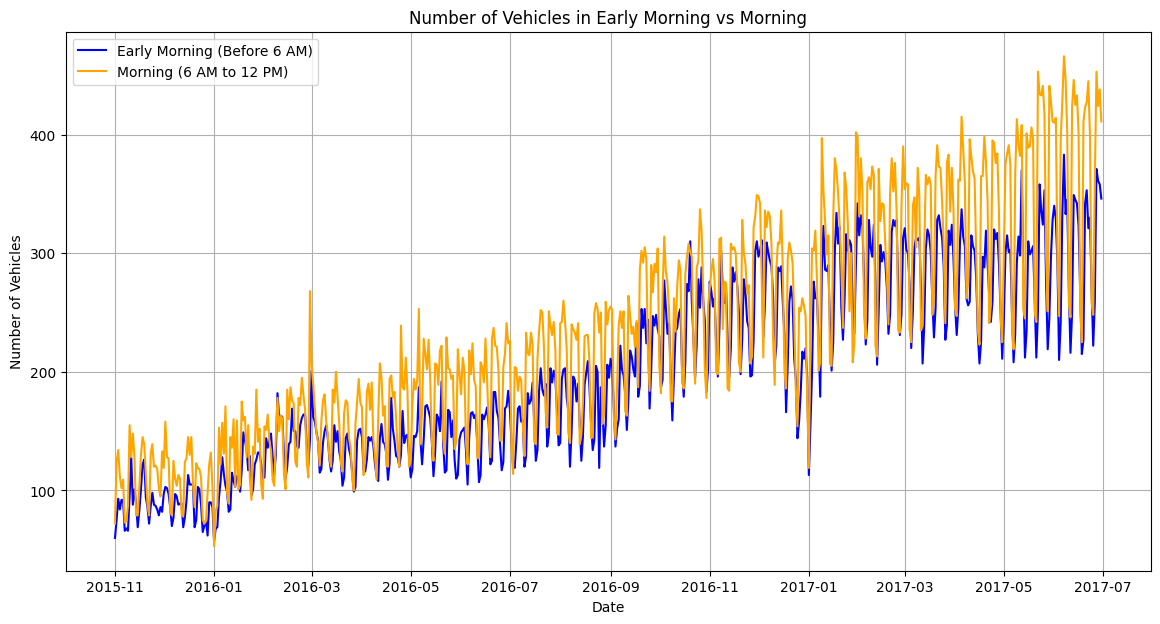

In [11]:
# Visualization of Early Morning Data
plt.figure(figsize=(14, 7))
plt.plot(early_morning_df['Date'], early_morning_df['Vehicles'], label='Early Morning (Before 6 AM)', color='blue')
plt.plot(morning_df['Date'], morning_df['Vehicles'], label='Morning (6 AM to 12 PM)', color='orange')
plt.xlabel('Date')
plt.ylabel('Number of Vehicles')
plt.title('Number of Vehicles in Early Morning vs Morning')
plt.legend()
plt.grid(True)
plt.show()

In [ ]:
#we can see Traffic increases significantly after 6 AM.
#The early morning period is less congested but follows a similar upward trend as the morning period

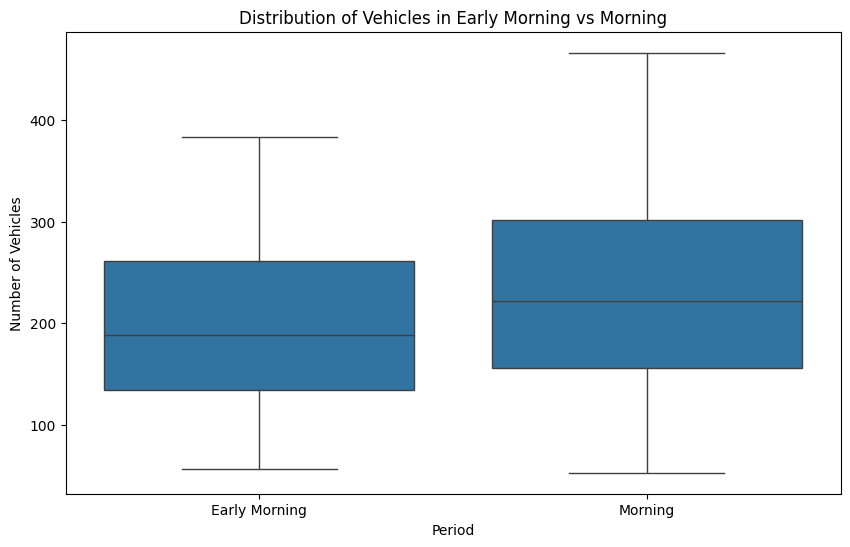

In [13]:
import seaborn as sns
import matplotlib.pyplot as plt

# Combine the data for visualization
early_morning_df['Period'] = 'Early Morning'
morning_df['Period'] = 'Morning'
combined_df = pd.concat([early_morning_df, morning_df])

# Create a box plot
plt.figure(figsize=(10, 6))
sns.boxplot(x='Period', y='Vehicles', data=combined_df)
plt.title('Distribution of Vehicles in Early Morning vs Morning')
plt.xlabel('Period')
plt.ylabel('Number of Vehicles')
plt.show()



## Split the data into train and test

In [29]:
# Convert the 'Date' column to numbers or encoded dates if necessary
X = morning_df['Date'].values.reshape(-1, 1)
y = morning_df['Vehicles'].values.reshape(-1, 1)

# Normalize the data using MinMaxScaler
scaler = MinMaxScaler()
y_scaled = scaler.fit_transform(y)

#Split the data into training and testing sets
# 70% of the data for training, 30% for testing, without shuffling
X_train, X_test, y_train, y_test = train_test_split(X, y_scaled, test_size=0.3, random_state=42, shuffle=False)


## Modeling


In [34]:
# Convert the 'Date' column to ordinal numbers (days since 01-01-0001)
X = morning_df['Date'].apply(lambda date: date.toordinal()).values.reshape(-1, 1)
y = morning_df['Vehicles'].values.reshape(-1, 1)

#Normalize the data using MinMaxScaler
scaler = MinMaxScaler()
y_scaled = scaler.fit_transform(y)

#Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y_scaled, test_size=0.3, random_state=42, shuffle=False)

#Reshape the input data to be compatible with RNN
X_train = X_train.reshape((X_train.shape[0], X_train.shape[1], 1))
X_test = X_test.reshape((X_test.shape[0], X_test.shape[1], 1))

In [35]:
 #Build the RNN model
# Initialize a sequential model
model = Sequential()

# First RNN layer with 50 units, input shape, and return sequences
model.add(SimpleRNN(units=50, return_sequences=True, input_shape=(X_train.shape[1], 1)))
model.add(Dropout(0.2))

# Second RNN layer with 50 units and return sequences
model.add(SimpleRNN(units=50, return_sequences=True))
model.add(Dropout(0.2))

# Third RNN layer with 50 units
model.add(SimpleRNN(units=50))
model.add(Dropout(0.2))

# Add a dense output layer with one unit
model.add(Dense(units=1))

# Display the model summary
model.summary()


Model: "sequential_5"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ simple_rnn_7 (SimpleRNN)             │ (None, 1, 50)               │           2,600 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_3 (Dropout)                  │ (None, 1, 50)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ simple_rnn_8 (SimpleRNN)             │ (None, 1, 50)               │           5,050 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_4 (Dropout)                  │ (None, 1, 50)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ simple_rnn_9 (SimpleRNN)             │ (None, 50)                  │           5,050 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_5 (Dropout)                  │ (None, 50)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_5 (Dense)                      │ (None, 1)                   │              51 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 12,751 (49.81 KB)

 Trainable params: 12,751 (49.81 KB)

 Non-trainable params: 0 (0.00 B)

In [36]:
 # Compile the model
model.compile(optimizer='adam', loss='mse')

In [37]:
 # Train the model
model.fit(X_train, y_train, epochs=100, batch_size=32)

Epoch 1/100
14/14 ━━━━━━━━━━━━━━━━━━━━ 5s 4ms/step - loss: 0.3659
Epoch 2/100
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.2477
Epoch 3/100
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.1930
Epoch 4/100
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.1694
Epoch 5/100
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.1458
Epoch 6/100
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.1261 
Epoch 7/100
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.1174
Epoch 8/100
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.1105
Epoch 9/100
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0929
Epoch 10/100
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0916
Epoch 11/100
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0772
Epoch 12/100
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0845
Epoch 13/100
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0864
Epoch 14/100
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0867
Epoch 15/100
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0819
Epo

In [38]:
 # Evaluate the model on the test data
model.evaluate(X_test, y_test)

6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.1059  


0.13236300647258759

In [54]:
from tensorflow.keras.layers import SimpleRNN

# Build the RNN model
model_rnn = Sequential()
model_rnn.add(SimpleRNN(units=50, return_sequences=True, input_shape=(X_train.shape[1], 1)))
model_rnn.add(Dropout(0.2))
model_rnn.add(SimpleRNN(units=50, return_sequences=True))
model_rnn.add(Dropout(0.2))
model_rnn.add(SimpleRNN(units=50))
model_rnn.add(Dropout(0.2))
model_rnn.add(Dense(units=1))

# Compile the RNN model
model_rnn.compile(optimizer='adam', loss='mse')

# Train the RNN model
model_rnn.fit(X_train, y_train, epochs=100, batch_size=32)

Epoch 1/100
14/14 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step - loss: 1.0333
Epoch 2/100
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.3232 
Epoch 3/100
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.2828 
Epoch 4/100
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.2381 
Epoch 5/100
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.2025 
Epoch 6/100
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.2160 
Epoch 7/100
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.1665
Epoch 8/100
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.1596
Epoch 9/100
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.1710 
Epoch 10/100
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.1154 
Epoch 11/100
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.1232 
Epoch 12/100
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0973
Epoch 13/100
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0857 
Epoch 14/100
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.1024 
Epoch 15/100
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0

In [43]:
# Generate predictions for the training and test sets
train_predict = model.predict(X_train)
test_predict = model.predict(X_test)

# Inverse transform the predictions to bring them back to the original scale
train_predict = scaler.inverse_transform(train_predict)
test_predict = scaler.inverse_transform(test_predict)

14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 29ms/step
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


In [47]:
# Calculate RMSE for training data
train_rmse = math.sqrt(mean_squared_error(y_train, train_predict))
print(f"Training RMSE: {train_rmse}")

# Calculate RMSE for test data
test_rmse = math.sqrt(mean_squared_error(y_test, test_predict))
print(f"Test RMSE: {test_rmse}")


Training RMSE: 202.17978364667115
Test RMSE: 201.82879077685598


**LSTM model**

In [52]:
from tensorflow.keras.layers import LSTM

# Build the LSTM model
model_lstm = Sequential()
model_lstm.add(LSTM(units=50, return_sequences=True, input_shape=(X_train.shape[1], 1)))
model_lstm.add(Dropout(0.2))
model_lstm.add(LSTM(units=50, return_sequences=True))
model_lstm.add(Dropout(0.2))
model_lstm.add(LSTM(units=50))
model_lstm.add(Dropout(0.2))
model_lstm.add(Dense(units=1))
# Display the model summary
model.summary()
# Compile the LSTM model
model_lstm.compile(optimizer='adam', loss='mse')

# Train the LSTM model
model_lstm.fit(X_train, y_train, epochs=100, batch_size=32)


Model: "sequential_5"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ simple_rnn_7 (SimpleRNN)             │ (None, 1, 50)               │           2,600 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_3 (Dropout)                  │ (None, 1, 50)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ simple_rnn_8 (SimpleRNN)             │ (None, 1, 50)               │           5,050 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_4 (Dropout)                  │ (None, 1, 50)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ simple_rnn_9 (SimpleRNN)             │ (None, 50)                  │           5,050 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_5 (Dropout)                  │ (None, 50)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_5 (Dense)                      │ (None, 1)                   │              51 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 38,255 (149.44 KB)

 Trainable params: 12,751 (49.81 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 25,504 (99.63 KB)

Epoch 1/100
14/14 ━━━━━━━━━━━━━━━━━━━━ 6s 5ms/step - loss: 0.1375
Epoch 2/100
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0480
Epoch 3/100
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0324
Epoch 4/100
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0289
Epoch 5/100
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0304
Epoch 6/100
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0306
Epoch 7/100
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0292
Epoch 8/100
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0283
Epoch 9/100
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0285
Epoch 10/100
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0262
Epoch 11/100
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0281
Epoch 12/100
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0283
Epoch 13/100
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0282
Epoch 14/100
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0274
Epoch 15/100
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0274
Epoc

**GRU model**

In [53]:
from tensorflow.keras.layers import GRU

# Build the GRU model
model_gru = Sequential()
model_gru.add(GRU(units=50, return_sequences=True, input_shape=(X_train.shape[1], 1)))
model_gru.add(Dropout(0.2))
model_gru.add(GRU(units=50, return_sequences=True))
model_gru.add(Dropout(0.2))
model_gru.add(GRU(units=50))
model_gru.add(Dropout(0.2))
model_gru.add(Dense(units=1))
# Display the model summary
model.summary()
# Compile the GRU model
model_gru.compile(optimizer='adam', loss='mse')

# Train the GRU model
model_gru.fit(X_train, y_train, epochs=100, batch_size=32)


Model: "sequential_5"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ simple_rnn_7 (SimpleRNN)             │ (None, 1, 50)               │           2,600 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_3 (Dropout)                  │ (None, 1, 50)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ simple_rnn_8 (SimpleRNN)             │ (None, 1, 50)               │           5,050 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_4 (Dropout)                  │ (None, 1, 50)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ simple_rnn_9 (SimpleRNN)             │ (None, 50)                  │           5,050 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_5 (Dropout)                  │ (None, 50)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_5 (Dense)                      │ (None, 1)                   │              51 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 38,255 (149.44 KB)

 Trainable params: 12,751 (49.81 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 25,504 (99.63 KB)

Epoch 1/100
14/14 ━━━━━━━━━━━━━━━━━━━━ 7s 9ms/step - loss: 0.0889
Epoch 2/100
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0368
Epoch 3/100
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0340
Epoch 4/100
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0337
Epoch 5/100
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0300
Epoch 6/100
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0295
Epoch 7/100
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0314
Epoch 8/100
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0308
Epoch 9/100
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0289
Epoch 10/100
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0275
Epoch 11/100
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0298
Epoch 12/100
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0316
Epoch 13/100
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0310
Epoch 14/100
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0280
Epoch 15/100
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0252
Epo

In [55]:
# Calculate RMSE for each model on the test data
rnn_rmse = math.sqrt(mean_squared_error(y_test, model_rnn.predict(X_test)))
lstm_rmse = math.sqrt(mean_squared_error(y_test, model_lstm.predict(X_test)))
gru_rmse = math.sqrt(mean_squared_error(y_test, model_gru.predict(X_test)))

print(f"RNN Test RMSE: {rnn_rmse}")
print(f"LSTM Test RMSE: {lstm_rmse}")
print(f"GRU Test RMSE: {gru_rmse}")

6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 77ms/step
6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 136ms/step


6/6 ━━━━━━━━━━━━━━━━━━━━ 2s 169ms/step
RNN Test RMSE: 0.35509978994285135
LSTM Test RMSE: 0.39558929889072636
GRU Test RMSE: 0.3933365143736672


## Visualization of results
